In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
import os
import random
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from collections import deque
import matplotlib.pylab as plt
from aux_plots import ploty_basic,plot_results
from agent import MinVarianceAgent, MaxSharpeAgent, MaxDecorrelationAgent, MaxReturnsAgent

Using TensorFlow backend.


In [2]:
class Factor_environment():
    
    def __init__(self,capital = 1e6,cotas = None):
        
        self.data = cotas.set_index("date")
                
    # considering each factor strat as an asset starting at price = 1  at  d0
    def load_data(self):
        
        return self.cotas
        
    def preprocess_state(self, state):
        
        return state
        
    
    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):
        
        assert lookback <= t
        
        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
    
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)
    
        
    def get_reward(self, action, action_t, reward_t):
        
        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])
        
        weights = action
        returns = self.data[action_t:reward_t].pct_change().dropna()
        
        rew = local_portfolio(returns, weights)[-1]
        rew = np.array([rew] * len(self.data.columns))
        
        return np.dot(returns, weights), rew

In [3]:
quotas = pd.read_csv("cotas_factors.csv")
quotas["date"] = quotas["date"].apply(lambda x: datetime.strptime(x,"%d/%m/%Y").date())
env = Factor_environment(cotas = quotas)
dados = env.data

# Parameters

In [4]:
# number of factors
N_ASSETS = 3

# lookbacj window to serve as input to the agent
WINDOW_FIT = 180

# fixed holding period !
WINDOW_HOLD = 60
env = Factor_environment(cotas = quotas)

In [5]:
agent_max_returns = MaxReturnsAgent(N_ASSETS, allow_short=True)
agent_minvar = MinVarianceAgent(N_ASSETS, allow_short=True)
agent_maxsharpe = MaxSharpeAgent(N_ASSETS, allow_short=True)
agent_maxdecorr = MaxDecorrelationAgent(N_ASSETS, allow_short=True)

# portfolio rebalancing: traditional methods

In [6]:
# actions =  new weights.
actions_equal, actions_returns, actions_minvar, actions_maxsharpe, actions_maxdecorr = [], [], [], [], []
result_equal, result_returns, result_minvar, result_maxsharpe, result_maxdecorr = [], [], [], [], []


# iterate day-to-day. 
list_datas = []
datas = env.data.index.tolist()
for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    list_datas.append(datas[i])
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_minvar = agent_minvar.act(state)
    action_max_returns = agent_max_returns.act(state)
    action_maxsharpe = agent_maxsharpe.act(state)
    action_maxdecorr = agent_maxdecorr.act(state)
    
    
    # return cov_matrix
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    
    # produto escar da matriz de covariancia com a matriz de pesos dos ativos;
    # retorna lista de lista em q cada lista 
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
        
    r = np.dot(state_action, action_minvar)
    result_minvar.append(r.tolist())
    actions_minvar.append(action_minvar)
        
    r = np.dot(state_action, action_max_returns)
    result_returns.append(r.tolist())
    actions_returns.append(action_max_returns)
       
    r = np.dot(state_action, action_maxsharpe)
    result_maxsharpe.append(r.tolist())
    actions_maxsharpe.append(action_maxsharpe)
        
    r = np.dot(state_action, action_maxdecorr)
    result_maxdecorr.append(r.tolist())
    actions_maxdecorr.append(action_maxdecorr)


    
datas_temp = pd.DataFrame({"date":list_datas})

# Evaluation
 - Lista de resultados concateandas

In [7]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_returns_vis = [item for sublist in result_returns for item in sublist]
result_minvar_vis = [item for sublist in result_minvar for item in sublist]
result_maxsharpe_vis = [item for sublist in result_maxsharpe for item in sublist]
result_maxdecorr_vis = [item for sublist in result_maxdecorr for item in sublist]

In [8]:
from datetime import datetime
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

def ploty_basic(df,x_data,y_data,mode_plot='line',title=None,
                y_title=None,x_title=None,type_plot="lines",
                multi_yaxes=False,anotations=None,width = 900,height = 700,
               not_pair = True,color_background='white',showgrid=True):
        

    if not isinstance(y_data, list):
        y_data = [y_data]
        x_data = [x_data]
        names = y_data.copy()
        
    else:
        if not isinstance(x_data, list):
            x_data = len(y_data)*[x_data]
            names = y_data.copy()
        else:
            x_data = len(y_data)*x_data
            names = y_data.copy()
      
    
    # todos os tracos iguaos
    if not isinstance(type_plot, list):
        if len(y_data)!=1:
            type_plot = len(y_data)*[type_plot]
        
        else:
            type_plot = [type_plot]
    
    else:
        
        if len(y_data)==1:
            type_plot = len(y_data)*type_plot
        

    '''
    
     - Caso se deseje destacar os pontos no grafico. Recebe o dataframe de pontos que se deseja 
    destacar
    
     - Esta implementado apenas para 1 plot
    
    '''
    
    lista_dict = []
    
    
    # anotacoes simples
    if ((anotations is not None)& (not_pair)):
        
        # dicionario layout
        d1 = dict(x=4,y=4,xref='x',yref='y',text='Annotation Text 2',showarrow=True,arrowhead=7,ax=0,ay=-40)
        
        lista_dict = []
        
        vals_x = anotations[x_data[0]].tolist()
        vals_y = anotations[y_data[0]].tolist()
        for el in range(len(vals_y)):
            dd = d1.copy()
            dd["x"] = vals_x[el]
            dd["y"] = vals_y[el]
            dd["text"] = 'trades_{}'.format(el)
            lista_dict.append(dd)
       
    
    # anotacoes de trades contendo o par de compra e venda de cada trade
    elif ((anotations is not None)& (not not_pair)):
        
        lista_dict = []
        
        vals_x_buy = anotations[x_data[0]+'_buy'].tolist()
        vals_y_buy = anotations[y_data[0]+'_buy'].tolist()
        vals_x_sell = anotations[x_data[0]+'_sell'].tolist()
        vals_y_sell = anotations[y_data[0]+'_sell'].tolist()

        d1 = dict(x=4,y=4,xref='x',yref='y',text='Annotation Text 2',showarrow=True,arrowhead=7,ax=0,ay=-40,arrowcolor='#636363')
        
        for el in range(len(vals_y_sell)):
            dd = d1.copy()
            dd2 = d1.copy()
            dd["x"] = vals_x_buy[el]
            dd["y"] = vals_y_buy[el]
            dd["text"] = 'trades_buy_{}'.format(el)
            dd["arrowcolor"] = '#636363'
            lista_dict.append(dd)

            dd2["x"] = vals_x_sell[el]
            dd2["y"] = vals_y_sell[el]
            dd2["text"] = 'trades_sell_{}'.format(el)
            dd2["arrowcolor"] = '#d9f441'
            lista_dict.append(dd2)
      
    
    data = []
    
    
    ## criamos uma lista de traces
    
    count = 1
        
    for el in range(len(x_data)):
        
        if mode_plot == 'line':
            trace = go.Scatter(
                        x=df['{}'.format(x_data[el])],
                        y=df['{}'.format(y_data[el])],
                        name = names[el],
                       mode = type_plot[el],
                       yaxis='y{}'.format(count)
                      )
                
        elif mode_plot =='bar':
            trace = go.Bar(
                x=df['{}'.format(x_data[el])],
                y=df['{}'.format(y_data[el])],
                name = names[el],
                opacity = 0.8)

        else:
            print("tipo invalido de Modo de plot")
        
        if multi_yaxes:
            count +=1
        

        data.append(trace)
            
    if not multi_yaxes:
    
        layout = dict(
            width=width,
            height=height,
            title = '{}'.format(title),
            yaxis = dict(title='{}'.format(y_title),showgrid=True,gridcolor='#bdbdbd'),
            xaxis = dict(title='{}'.format(x_title),showgrid=True,gridcolor='#bdbdbd'),
            annotations=lista_dict,
            #showgrid = showgrid,
            plot_bgcolor=color_background
            )
    
    else:
        
        layout = go.Layout(
            width=width,
            height=height,
            title=title,
            yaxis=dict(
                title='yaxis title',
                showgrid=True,gridcolor='#bdbdbd'
            ),
            yaxis2=dict(
                showgrid=True,gridcolor='#bdbdbd',
                title='yaxis2 title',
                titlefont=dict(
                    color='rgb(148, 103, 189)'
                ),
                tickfont=dict(
                    color='rgb(148, 103, 189)'
                ),
                overlaying='y',
                side='right'
            ),
        annotations=lista_dict,
        plot_bgcolor=color_background
        )
       
        
    #ata = [trace]
    fig = go.Figure(data = data,layout=layout )

    #fig = dict(data=data, layout=layout)
    #fig.show("png")
    fig.show("svg")

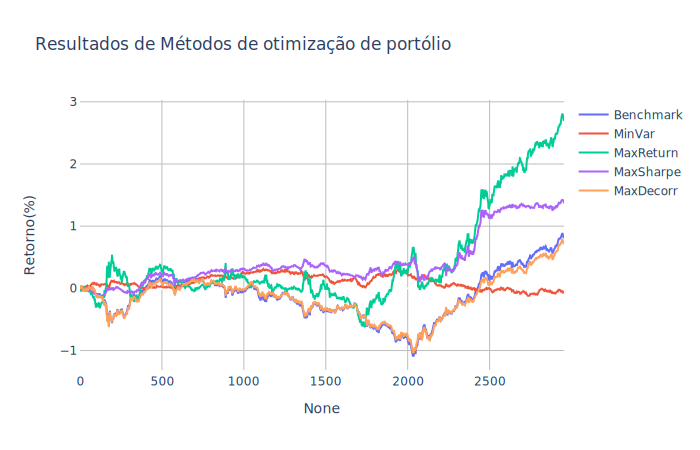

In [9]:
df_eqt = pd.DataFrame({"Benchmark":np.array(result_equal_vis).cumsum(),
              "MinVar":np.array(result_minvar_vis).cumsum(),
              "MaxReturn":np.array(result_returns_vis).cumsum(),
              "MaxSharpe":np.array(result_maxsharpe_vis).cumsum(),
              "MaxDecorr":np.array(result_maxdecorr_vis).cumsum()})

df_eqt["x"] = df_eqt.index
df_eqt

ploty_basic(df_eqt,"x",["Benchmark","MinVar","MaxReturn","MaxSharpe","MaxDecorr"],title="Resultados de Métodos de otimização de portólio",y_title="Retorno(%)")

# Visualization

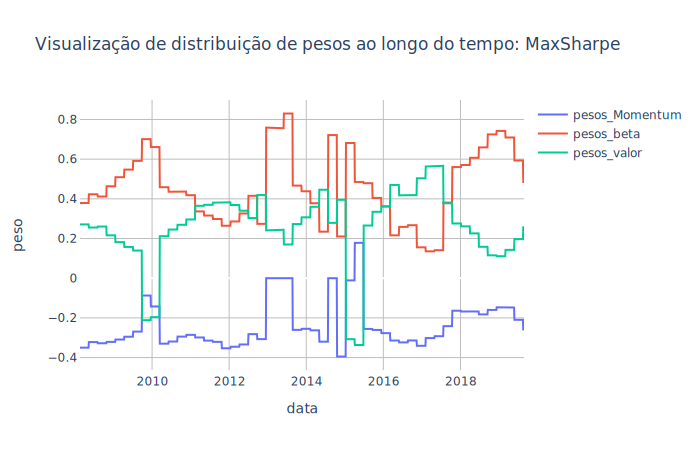

In [10]:
def createSeries(datas_temp,lista_actions):
    lista_vol = []
    lista_mom = []
    lista_beta = []
    lista_valor = []
    for el in range(len(lista_actions)):
        #lista_vol.append(lista_actions[el][0])
        lista_mom.append(lista_actions[el][0])
        lista_beta.append(lista_actions[el][1])
        lista_valor.append(lista_actions[el][2])
        
    df_weights = pd.DataFrame({"date":datas_temp["date"].tolist(),
                               "pesos_Momentum":lista_mom,"pesos_beta":lista_beta,"pesos_valor":lista_valor})    
    return df_weights



ww = createSeries(datas_temp,actions_minvar)
datas_full = pd.DataFrame({"date":dados.index.tolist()})
datas_full["val"] = 1
complete = pd.merge(datas_full,ww,left_on=["date"],right_on="date",how="left")
dt_min = complete[~pd.isnull(complete["pesos_beta"])]["date"].min()
complete = complete[complete["date"]>=dt_min]
complete.fillna(method='ffill',inplace=True)



ploty_basic(complete,"date",["pesos_Momentum","pesos_beta","pesos_valor"],title="Visualização de distribuição de pesos ao longo do tempo: MaxSharpe",y_title="peso",x_title="data")

# portfolio rebalancing: autoencoder

In [11]:
from agent import AutoencoderAgent

In [12]:
agent_ae = AutoencoderAgent(N_ASSETS, allow_short=True, encoding_dim = 5)

In [13]:
actions_equal, actions_ae = [], []
result_equal, result_ae = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_ae = agent_ae.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_ae)
    result_ae.append(r.tolist())
    actions_ae.append(action_ae)

In [14]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_ae_vis = [item for sublist in result_ae for item in sublist]

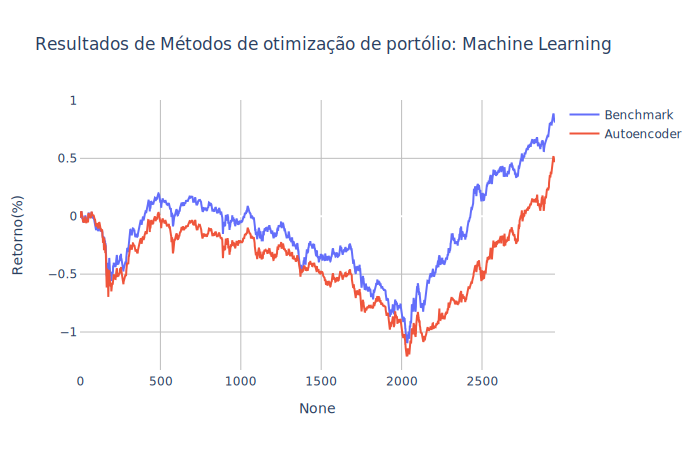

In [15]:
df_eqt = pd.DataFrame({"Benchmark":np.array(result_equal_vis).cumsum(),
                        "Autoencoder":np.array(result_ae_vis).cumsum()})


df_eqt["x"] = df_eqt.index
df_eqt

ploty_basic(df_eqt,"x",["Benchmark","Autoencoder"],title="Resultados de Métodos de otimização de portólio: Machine Learning",y_title="Retorno(%)")
#ploty_basic(df_eqt,"x",["Benchmark","MinVar","MaxReturn","MaxSharpe","MaxDecorr"],title="Resultados de Métodos de otimização de portólio",y_title="Retorno(%)")

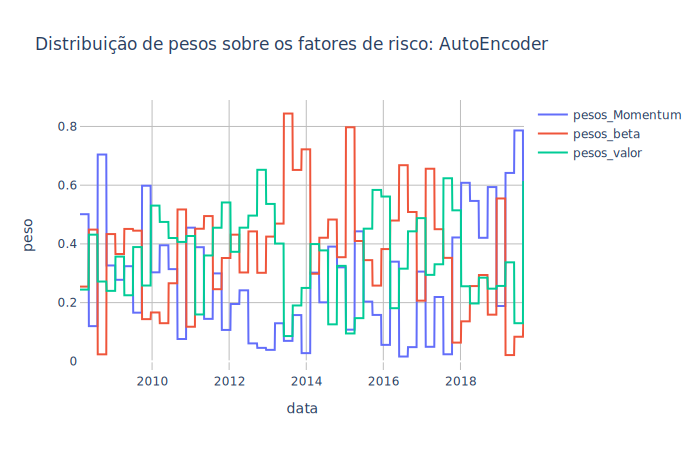

In [16]:
def createSeries(datas_temp,lista_actions):
    lista_vol = []
    lista_mom = []
    lista_beta = []
    lista_valor = []
    for el in range(len(lista_actions)):
        #lista_vol.append(lista_actions[el][0])
        lista_mom.append(lista_actions[el][0])
        lista_beta.append(lista_actions[el][1])
        lista_valor.append(lista_actions[el][2])
        
    df_weights = pd.DataFrame({"date":datas_temp["date"].tolist(),
                               "pesos_Momentum":lista_mom,"pesos_beta":lista_beta,"pesos_valor":lista_valor})    
    return df_weights


ww = createSeries(datas_temp,actions_ae)
datas_full = pd.DataFrame({"date":dados.index.tolist()})
datas_full["val"] = 1
complete = pd.merge(datas_full,ww,left_on=["date"],right_on="date",how="left")
dt_min = complete[~pd.isnull(complete["pesos_beta"])]["date"].min()
complete = complete[complete["date"]>=dt_min]
complete.fillna(method='ffill',inplace=True)


ploty_basic(complete,"date",["pesos_Momentum","pesos_beta","pesos_valor"],title="Distribuição de pesos sobre os fatores de risco: AutoEncoder",y_title="peso",x_title="data")